<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Detector_de_rostros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPARACION POR DISTANCIA EUCLIDIANA Y DISTANCIA COSENO**

##Formulas aplicadas:

$$
d_{\text{eucl}}(\mathbf{a}, \mathbf{b}) = \| \mathbf{a} - \mathbf{b} \|_2
= \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
$$


$$
d_{\cos}(\mathbf{a}, \mathbf{b}) = 1 - \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\|\|\mathbf{b}\|}
$$


Sube exactamente 3 im√°genes (JPG/PNG) con un rostro cada una‚Ä¶


Saving NeymarJr2.jpg to NeymarJr2 (2).jpg
Saving Robert_Downey1.jpg to Robert_Downey1 (2).jpg
Saving Robert_Downey2.jpg to Robert_Downey2 (2).jpg

=== Distancias entre pares (mejor visualizadas) ===



PAREJA M√ÅS PROBABLE (misma persona): Robert_Downey1 (2).jpg ‚Üî Robert_Downey2 (2).jpg


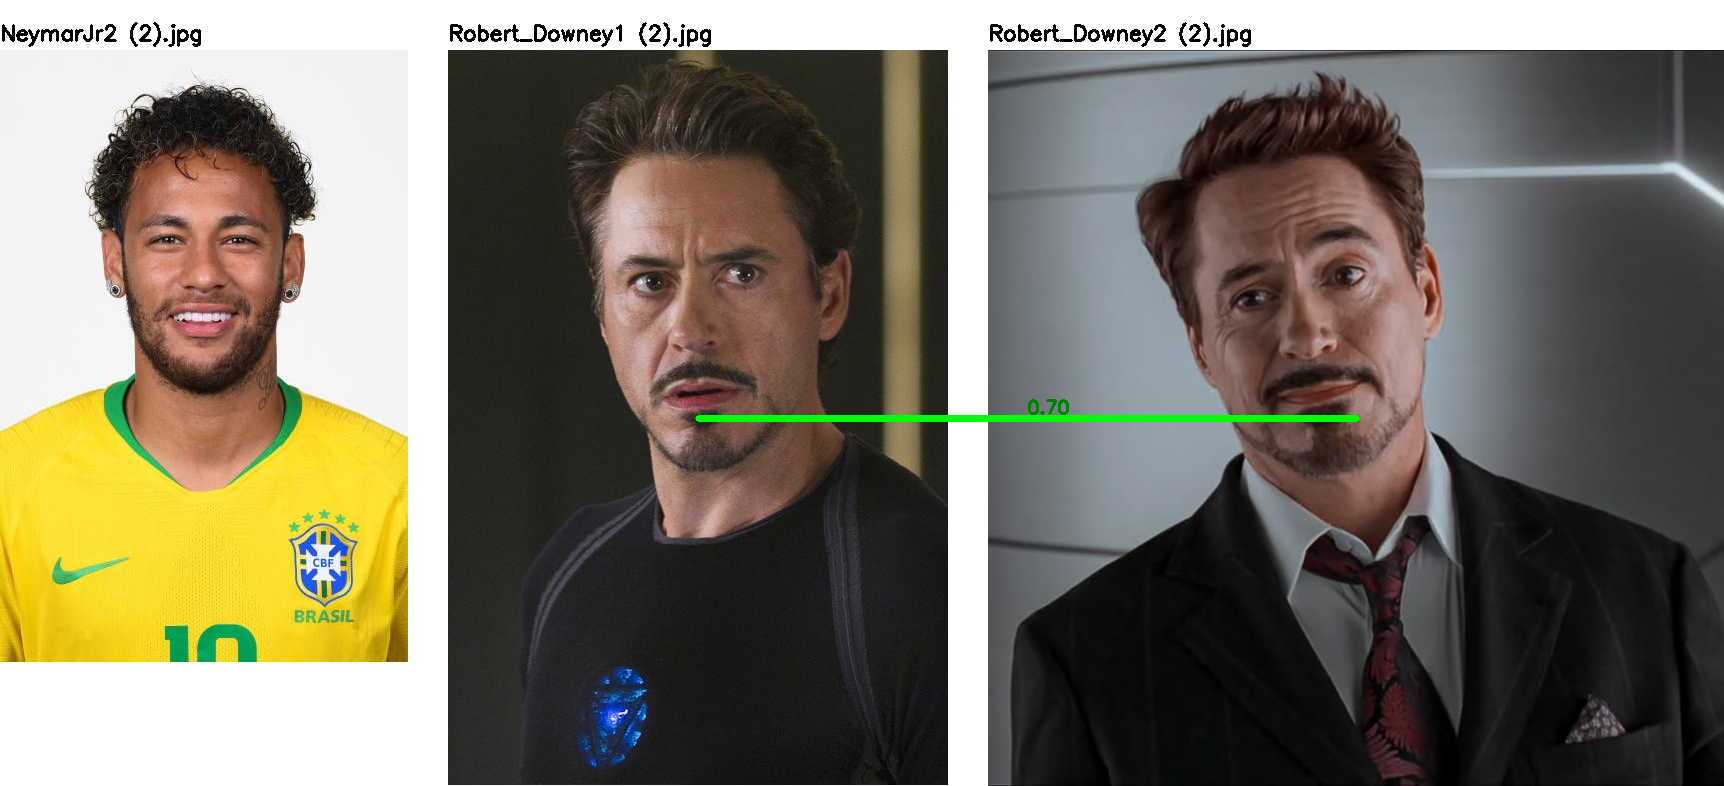

In [ ]:
# --- 1) Instalaci√≥n de dependencias ---
#!pip -q install facenet-pytorch torch torchvision --upgrade

# --- 2) Importaciones ---
from google.colab import files
from PIL import Image
import torch
import numpy as np
import pandas as pd
import itertools
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from google.colab.patches import cv2_imshow

# --- 3) Subir im√°genes ---
print("Sube exactamente 3 im√°genes (JPG/PNG) con un rostro cada una‚Ä¶")
uploaded = files.upload()
filenames = list(uploaded.keys())
if len(filenames) != 3:
    raise ValueError(f"Debes subir exactamente 3 im√°genes. Subiste: {len(filenames)}")

# --- 4) Preparar detector y red de embeddings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def load_and_embed(path):
    img = Image.open(path).convert('RGB')
    face_tensor = mtcnn(img)
    if face_tensor is None:
        raise ValueError(
            f"No se detect√≥ rostro en: {path}. "
            "Usa im√°genes con la cara centrada y bien iluminada."
        )
    face_tensor = face_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(face_tensor).cpu().numpy().flatten()
    return emb

# --- 5) Obtener embeddings ---
embeddings = {}
for name in filenames:
    embeddings[name] = load_and_embed(name)

# --- 6) Calcular distancias entre pares ---
def euclidean(a, b):
    return float(np.linalg.norm(a - b))

def cosine_distance(a, b):
    return 1.0 - (float(np.dot(a, b)) / (float(np.linalg.norm(a) * np.linalg.norm(b))))

pairs = list(itertools.combinations(filenames, 2))
rows = []
for (fa, fb) in pairs:
    ea, eb = embeddings[fa], embeddings[fb]
    rows.append({
        "Par": f"{fa} ‚Üî {fb}",
        "Distancia eucl√≠dea (‚Üì=m√°s parecidas)": euclidean(ea, eb),
        "Distancia de coseno (‚Üì=m√°s parecidas)": cosine_distance(ea, eb),
    })

df = pd.DataFrame(rows).sort_values(by="Distancia eucl√≠dea (‚Üì=m√°s parecidas)")

# --- Mostrar tabla mejorada ---
df_styled = df.style.format(precision=3)

# Resaltar la fila con menor distancia eucl√≠dea
min_dist = df["Distancia eucl√≠dea (‚Üì=m√°s parecidas)"].min()
df_styled = df_styled.apply(
    lambda row: ['background-color: lightgreen' if row["Distancia eucl√≠dea (‚Üì=m√°s parecidas)"] == min_dist else '' for _ in row],
    axis=1
)

# Resaltar columnas con gradiente de colores
df_styled = df_styled.background_gradient(
    subset=["Distancia eucl√≠dea (‚Üì=m√°s parecidas)", "Distancia de coseno (‚Üì=m√°s parecidas)"],
    cmap="RdYlGn_r"
)

print("\n=== Distancias entre pares (mejor visualizadas) ===")
display(df_styled)


best_pair = df.iloc[0]["Par"]
print(f"\nPAREJA M√ÅS PROBABLE (misma persona): {best_pair}")

# --- 7) Visualizaci√≥n ---
# Convertir PIL ‚Üí OpenCV
cv_images = {}
for name in filenames:
    img = Image.open(name).convert('RGB')
    cv_img = np.array(img)[:, :, ::-1]  # RGB ‚Üí BGR
    cv_images[name] = cv_img

# Crear lienzo
alto_max = max(cv_images[n].shape[0] for n in filenames)
ancho_total = sum(cv_images[n].shape[1] for n in filenames) + 40*(len(filenames)-1)
canvas = np.ones((alto_max+50, ancho_total, 3), dtype=np.uint8)*255

# Colocar im√°genes y nombres
x_offset = 0
posiciones = {}
for name in filenames:
    img = cv_images[name]
    h, w, _ = img.shape
    canvas[50:h+50, x_offset:x_offset+w] = img
    cv2.putText(canvas, name, (x_offset, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
    posiciones[name] = (x_offset, w)
    x_offset += w + 40

# Dibujar l√≠neas verdes entre similares
umbral_similar = 0.8  # ajustable
for row in rows:
    fa, fb = row["Par"].split(" ‚Üî ")
    distancia = row["Distancia eucl√≠dea (‚Üì=m√°s parecidas)"]
    if distancia < umbral_similar:
        xi = posiciones[fa][0] + posiciones[fa][1]//2
        xj = posiciones[fb][0] + posiciones[fb][1]//2
        cv2.line(canvas, (xi, alto_max//2 + 50), (xj, alto_max//2 + 50), (0,255,0), 5)
        cv2.putText(canvas, f"{distancia:.2f}", ((xi+xj)//2, alto_max//2 + 45),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,128,0), 2)

# Mostrar resultado
cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()


# **COMPARACION POR SOLUCION ANALITICA**


# F√≥rmula aplicada:
$$
\alpha = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{b}\|^2}
$$



In [ ]:
import torch
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from google.colab import files
import itertools

# 1) Subida de im√°genes
print("üìÇ Sube tus im√°genes (ejemplo: Messi1, Messi2, CR7)...")
uploaded = files.upload()
filenames = list(uploaded.keys())

# 2) Preparar detector y red de embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def load_and_embed(path):
    """Carga imagen, detecta rostro y devuelve embedding de 512D."""
    img = Image.open(path).convert('RGB')
    face_tensor = mtcnn(img)
    if face_tensor is None:
        raise ValueError(f"No se detect√≥ rostro en {path}")
    face_tensor = face_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(face_tensor).cpu().numpy().flatten()
    return emb

# 3) Calcular embeddings de todas las im√°genes
embeddings = {name: load_and_embed(name) for name in filenames}

# 4) Comparaciones anal√≠ticas (solo pares √∫nicos)
resultados = []
print("\n=== RESULTADOS ANAL√çTICOS POR PARES ===")
for (fa, fb) in itertools.combinations(filenames, 2):
    a, b = embeddings[fa], embeddings[fb]

    dot_product = np.dot(a, b)
    norm_b_squared = np.dot(b, b)
    alpha = dot_product / norm_b_squared if norm_b_squared != 0 else 0

    print(f"\nPar: {fa} ‚Üî {fb}")
    print(f"   Producto punto (a ¬∑ b): {dot_product:.4f}")
    print(f"   Norma de b al cuadrado (||b||^2): {norm_b_squared:.4f}")
    print(f"   Alpha = (a ¬∑ b) / (||b||^2) = {alpha:.4f}")

    resultados.append({
        "Par": f"{fa} ‚Üî {fb}",
        "Producto punto (a¬∑b)": dot_product,
        "Norma ||b||¬≤": norm_b_squared,
        "Alpha": alpha
    })

# 5) Tabla resumen ordenada por Alpha
df = pd.DataFrame(resultados)
df = df.sort_values(by="Alpha", ascending=False).reset_index(drop=True)

print("\n=== TABLA RESUMEN (ordenada por Œ±) ===")
display(df)


üìÇ Sube tus im√°genes (ejemplo: Messi1, Messi2, CR7)...


Saving NeymarJr2.jpg to NeymarJr2 (3).jpg
Saving Robert_Downey1.jpg to Robert_Downey1 (3).jpg
Saving Robert_Downey2.jpg to Robert_Downey2 (3).jpg

=== RESULTADOS ANAL√çTICOS POR PARES ===

Par: NeymarJr2 (3).jpg ‚Üî Robert_Downey1 (3).jpg
   Producto punto (a ¬∑ b): -0.0670
   Norma de b al cuadrado (||b||^2): 1.0000
   Alpha = (a ¬∑ b) / (||b||^2) = -0.0670

Par: NeymarJr2 (3).jpg ‚Üî Robert_Downey2 (3).jpg
   Producto punto (a ¬∑ b): -0.0692
   Norma de b al cuadrado (||b||^2): 1.0000
   Alpha = (a ¬∑ b) / (||b||^2) = -0.0692

Par: Robert_Downey1 (3).jpg ‚Üî Robert_Downey2 (3).jpg
   Producto punto (a ¬∑ b): 0.7569
   Norma de b al cuadrado (||b||^2): 1.0000
   Alpha = (a ¬∑ b) / (||b||^2) = 0.7569

=== TABLA RESUMEN (ordenada por Œ±) ===


Par  Producto punto (a¬∑b)  \
0  Robert_Downey1 (3).jpg ‚Üî Robert_Downey2 (3).jpg              0.756878   
1       NeymarJr2 (3).jpg ‚Üî Robert_Downey1 (3).jpg             -0.066981   
2       NeymarJr2 (3).jpg ‚Üî Robert_Downey2 (3).jpg             -0.069233   

   Norma ||b||¬≤     Alpha  
0           1.0  0.756878  
1           1.0 -0.066981  
2           1.0 -0.069233

In [ ]:
# --- ) Instalaci√≥n de dependencias ---
# Las siguientes l√≠neas se usan si no tienes instalado PyTorch y facenet-pytorch
!pip -q install --upgrade torch torchvision torchaudio
!pip -q install --upgrade facenet-pytorch

# **COMPARACION POR SOLUCION ITERATIVA (GRADIANTE DESCENDENTE)**

##Formulas utilizadas:

Derivada de la perdida con respecto alpha:

$$
\frac{\partial L(\alpha)}{\partial \alpha}
= -2 \sum_{i=1}^n (a_i - \alpha b_i)\, b_i
$$

Actualizacion de alpha por gradiante descendente:

$$
\alpha \; \leftarrow \; \alpha - \eta \, \frac{\partial L(\alpha)}{\partial \alpha}
$$



In [ ]:

# --- 1) Importaciones ---
from google.colab import files        # Para subir archivos al Colab
from PIL import Image                  # Para manejar im√°genes
import torch                           # PyTorch, para redes neuronales
import numpy as np                     # Para operaciones num√©ricas
import pandas as pd                    # Para manejar tablas y resultados
import itertools                       # Para generar combinaciones de im√°genes
from facenet_pytorch import MTCNN, InceptionResnetV1  # Detector de rostros y red de embeddings
import cv2                             # OpenCV, para mostrar im√°genes y dibujar
from google.colab.patches import cv2_imshow  # Para mostrar im√°genes en Colab
import matplotlib.pyplot as plt        # Para gr√°ficas

# --- 2) Subir im√°genes ---
print("Sube exactamente 3 im√°genes (JPG/PNG) con un rostro cada una‚Ä¶")
uploaded = files.upload()  # Ventana para seleccionar las im√°genes
filenames = list(uploaded.keys())
if len(filenames) != 3:
    raise ValueError(f"Debes subir exactamente 3 im√°genes. Subiste: {len(filenames)}")

# --- 3) Preparar detector y red de embeddings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Usar GPU si est√° disponible
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)  # Detector de rostros
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)         # Red de embeddings

# --- Funci√≥n para cargar imagen y obtener embedding ---
def load_and_embed(path):
    img = Image.open(path).convert('RGB')  # Abrir la imagen y convertir a RGB
    face_tensor = mtcnn(img)               # Detectar el rostro y recortar
    if face_tensor is None:
        raise ValueError(
            f"No se detect√≥ rostro en: {path}. Usa im√°genes centradas y bien iluminadas."
        )
    face_tensor = face_tensor.unsqueeze(0).to(device)  # A√±adir batch y mover a GPU/CPU
    with torch.no_grad():                              # No necesitamos gradientes aqu√≠
        emb = resnet(face_tensor).cpu().numpy().flatten()  # Obtener embedding y convertir a vector
    return emb

# --- 4) Obtener embeddings de todas las im√°genes ---
embeddings = {}
for name in filenames:
    embeddings[name] = load_and_embed(name)  # Guardar cada embedding en un diccionario

# --- 5) Gradiente descendente sobre alpha ---
# Funci√≥n que calcula la derivada de la p√©rdida ||a - Œ±b||^2 con respecto a Œ±
def grad_loss(alpha, a, b):
    return -2 * np.sum((a - alpha * b) * b)

# Funci√≥n que optimiza Œ± usando gradiente descendente
def optimize_alpha(a, b, alpha0=0.5, lr=0.01, iterations=50):
    alpha = alpha0
    alpha_history = [alpha]  # Guardar el historial para graficar la convergencia
    for _ in range(iterations):
        alpha -= lr * grad_loss(alpha, a, b)  # Actualizar Œ± seg√∫n gradiente
        alpha_history.append(alpha)
    loss_min = np.sum((a - alpha*b)**2)  # Calcular la p√©rdida final m√≠nima
    return alpha, loss_min, alpha_history

# --- 6) Calcular pares de im√°genes y optimizar Œ± para cada par ---
pairs = list(itertools.combinations(filenames, 2))  # Todas las combinaciones de pares
rows = []                                           # Lista para tabla de resultados
alpha_histories = {}                                # Guardar historial de Œ± de cada par
for (fa, fb) in pairs:
    ea, eb = embeddings[fa], embeddings[fb]        # Embeddings de las dos im√°genes
    alpha_opt, min_loss, alpha_history = optimize_alpha(ea, eb)  # Optimizar Œ±
    rows.append({
        "Par": f"{fa} ‚Üî {fb}",
        "Alpha √≥ptimo": alpha_opt,
        "P√©rdida m√≠nima (‚Üì=m√°s parecidas)": min_loss
    })
    alpha_histories[f"{fa} ‚Üî {fb}"] = alpha_history  # Guardar historia de Œ±

# Convertir resultados en DataFrame y ordenar por p√©rdida m√≠nima
df = pd.DataFrame(rows).sort_values(by="P√©rdida m√≠nima (‚Üì=m√°s parecidas)")

# --- 7) Mostrar tabla estilizada ---
df_styled = df.style.format(precision=3)  # Formato con 3 decimales
min_loss = df["P√©rdida m√≠nima (‚Üì=m√°s parecidas)"].min()
df_styled = df_styled.apply(
    lambda row: ['background-color: lightgreen' if row["P√©rdida m√≠nima (‚Üì=m√°s parecidas)"] == min_loss else '' for _ in row],
    axis=1
)
df_styled = df_styled.background_gradient(
    subset=["P√©rdida m√≠nima (‚Üì=m√°s parecidas)"],
    cmap="RdYlGn_r"
)
print("\n=== Distancias entre pares usando gradiente descendente sobre alpha ===")
display(df_styled)

# Mostrar la pareja m√°s probable (misma persona)
best_pair = df.iloc[0]["Par"]
print(f"\nPAREJA M√ÅS PROBABLE (misma persona): {best_pair}")

# --- 8) Visualizaci√≥n de im√°genes y l√≠neas verdes entre similares ---
cv_images = {}
for name in filenames:
    img = Image.open(name).convert('RGB')
    cv_img = np.array(img)[:, :, ::-1]  # Convertir de RGB a BGR para OpenCV
    cv_images[name] = cv_img

# Crear un lienzo para colocar todas las im√°genes
alto_max = max(cv_images[n].shape[0] for n in filenames)
ancho_total = sum(cv_images[n].shape[1] for n in filenames) + 40*(len(filenames)-1)
canvas = np.ones((alto_max+50, ancho_total, 3), dtype=np.uint8)*255  # Fondo blanco

# Colocar im√°genes en el lienzo
x_offset = 0
posiciones = {}
for name in filenames:
    img = cv_images[name]
    h, w, _ = img.shape
    canvas[50:h+50, x_offset:x_offset+w] = img
    cv2.putText(canvas, name, (x_offset, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
    posiciones[name] = (x_offset, w)
    x_offset += w + 40

# Dibujar l√≠neas verdes entre im√°genes consideradas similares
umbral_similar = df["P√©rdida m√≠nima (‚Üì=m√°s parecidas)"].max()*0.7
for row in rows:
    fa, fb = row["Par"].split(" ‚Üî ")
    if row["P√©rdida m√≠nima (‚Üì=m√°s parecidas)"] < umbral_similar:
        xi = posiciones[fa][0] + posiciones[fa][1]//2
        xj = posiciones[fb][0] + posiciones[fb][1]//2
        cv2.line(canvas, (xi, alto_max//2 + 50), (xj, alto_max//2 + 50), (0,255,0), 5)
        cv2.putText(canvas, f"{row['P√©rdida m√≠nima (‚Üì=m√°s parecidas)']:.2f}", ((xi+xj)//2, alto_max//2 + 45),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,128,0), 2)

cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

# --- 9) Graficar p√©rdida por referencia (una gr√°fica por imagen) ---
# Aqu√≠ graficamos c√≥mo convergen los Œ± para cada imagen de referencia
for ref_name in filenames:
    ref_emb = embeddings[ref_name]
    plt.figure(figsize=(10,6))
    for target_name in filenames:
        if target_name == ref_name:
            continue  # No comparamos la imagen consigo misma
        target_emb = embeddings[target_name]
        alpha_opt, loss_min, alpha_history = optimize_alpha(ref_emb, target_emb)
        # Curva de p√©rdida vs Œ±
        alpha_vals = np.linspace(0, 2, 200)
        loss_vals = [np.sum((ref_emb - a*target_emb)**2) for a in alpha_vals]
        plt.plot(alpha_vals, loss_vals, label=f"{target_name} (min={loss_min:.2f})")
        # Historial de Œ± de gradiente descendente como puntos
        loss_hist = [np.sum((ref_emb - a*target_emb)**2) for a in alpha_history]
        plt.scatter(alpha_history, loss_hist, s=20)

    plt.xlabel("Alpha")                           # Eje x: Œ±
    plt.ylabel("P√©rdida ||ref - Œ± target||^2")  # Eje y: p√©rdida
    plt.title(f"Proyecci√≥n por gradiente descendente - Referencia: {ref_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


Sube exactamente 3 im√°genes (JPG/PNG) con un rostro cada una‚Ä¶


Saving NeymarJr2.jpg to NeymarJr2 (4).jpg
Saving Robert_Downey1.jpg to Robert_Downey1 (4).jpg
Saving Robert_Downey2.jpg to Robert_Downey2 (4).jpg

=== Distancias entre pares usando gradiente descendente sobre alpha ===



PAREJA M√ÅS PROBABLE (misma persona): Robert_Downey1 (4).jpg ‚Üî Robert_Downey2 (4).jpg
